100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2941.37it/s]


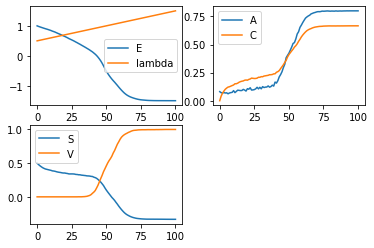

Creating locations for adjacency graphs...


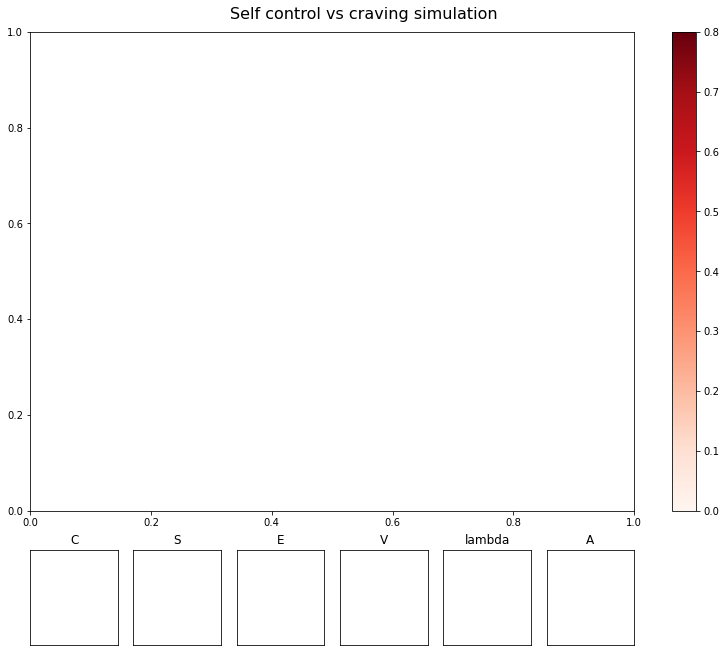

C:\Users\jnevin\Anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from dynsimf.models.Model import Model
from dynsimf.models.Model import ModelConfiguration

# Network definition
g = nx.random_geometric_graph(250, 0.125)
cfg = {
    'utility': False,
}
model = Model(g, ModelConfiguration(cfg))

constants = {
    'q': 0.8,
    'b': 0.5,
    'd': 0.2,
    'h': 0.2,
    'k': 0.25,
    'S+': 0.5,
}
constants['p'] = 2*constants['d']

def initial_v(constants):
    return np.minimum(1, np.maximum(0, model.get_state('C') - model.get_state('S') - model.get_state('E')))

def initial_a(constants):
    return constants['q'] * model.get_state('V') + (np.random.poisson(model.get_state('lambda'))/7)

initial_state = {
    'C': 0,
    'S': constants['S+'],
    'E': 1,
    'V': initial_v,
    'lambda': 0.5,
    'A': initial_a
}

def update_C(constants):
    c = model.get_state('C') + constants['b'] * model.get_state('A') * np.minimum(1, 1-model.get_state('C')) - constants['d'] * model.get_state('C')
    return {'C': c}

def update_S(constants):
    return {'S': model.get_state('S') + constants['p'] * np.maximum(0, constants['S+'] - model.get_state('S')) - constants['h'] * model.get_state('C') - constants['k'] * model.get_state('A')}

def update_E(constants):
    adj = model.get_adjacency()
    summed = np.matmul(adj, model.get_nodes_states())
    e = summed[:, model.get_state_index('A')] / 50
    return {'E': np.maximum(-1.5, model.get_state('E') - e)}

def update_V(constants):
    return {'V': np.minimum(1, np.maximum(0, model.get_state('C')-model.get_state('S')-model.get_state('E')))}

def update_lambda(constants):
    return {'lambda': model.get_state('lambda') + 0.01}

def update_A(constants):
    return {'A': constants['q'] * model.get_state('V') + np.minimum((np.random.poisson(model.get_state('lambda'))/7), constants['q']*(1 - model.get_state('V')))}

# Model definition
model.constants = constants
model.set_states(['C', 'S', 'E', 'V', 'lambda', 'A'])
model.add_update(update_C, {'constants': model.constants})
model.add_update(update_S, {'constants': model.constants})
model.add_update(update_E, {'constants': model.constants})
model.add_update(update_V, {'constants': model.constants})
model.add_update(update_lambda, {'constants': model.constants})
model.add_update(update_A, {'constants': model.constants})
model.set_initial_state(initial_state, {'constants': model.constants})

its = model.simulate(100)

iterations = its['states'].values()

A = [np.mean(it[:, 5]) for it in iterations]
C = [np.mean(it[:, 0]) for it in iterations]

E = [np.mean(it[:, 2]) for it in iterations]
lmd = [np.mean(it[:, 4]) for it in iterations]

S = [np.mean(it[:, 1]) for it in iterations]
V = [np.mean(it[:, 3]) for it in iterations]

x = np.arange(0, len(iterations))
plt.figure()

plt.subplot(221)
plt.plot(x, E, label='E')
plt.plot(x, lmd, label='lambda')
plt.legend()

plt.subplot(222)
plt.plot(x, A, label='A')
plt.plot(x, C, label='C')
plt.legend()

plt.subplot(223)
plt.plot(x, S, label='S')
plt.plot(x, V, label='V')
plt.legend()

plt.show()

visualization_config = {
    'plot_interval': 2,
    'initial_positions': nx.get_node_attributes(g, 'pos'),
    'plot_variable': 'A',
    'color_scale': 'Reds',
    'variable_limits': {
        'A': [0, 0.8],
        'lambda': [0.5, 1.5],
        'C': [-1, 1],
        'V': [-1, 1],
        'E': [-1, 1],
        'S': [-1, 1]
    },
    'show_plot': True,
    # 'plot_output': './animations/c_vs_s.gif',
    'plot_title': 'Self control vs craving simulation',
}

model.configure_visualization(visualization_config, its)
model.visualize('animation')